# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

/Users/dmitrygavrilenko/miniconda3/envs/RoboND/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [4]:
learning_rate = 0.01
batch_size = 23
num_epochs = 75
layers_num = 1
conv_layers_num = 3
external_features = 64
internal_features = 32
conv_features = 23

In [5]:
steps_per_epoch = 200
validation_steps = 50
workers = 2

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [6]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    upsampled = bilinear_upsample(small_ip_layer)
    
    concatenated = layers.concatenate([upsampled, large_ip_layer])

    output_layer = separable_conv2d_batchnorm(concatenated, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
def fcn_model(inputs, num_classes):
    v = inputs
    
    layer_list = []
    for _ in range(layers_num):
        layer_list.append(v)
        
        if v == input:
            v = encoder_block(v, external_features, 2)
        else:
            v = encoder_block(v, internal_features, 2)
        
    for _ in range(conv_layers_num):
        v = conv2d_batchnorm(v, conv_features)

    for _ in range(layers_num):
        v = decoder_block(v, layer_list.pop(), internal_features)
    
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(v)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Epoch 1/75


/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):


199/200 [============================>.] - ETA: 0s - loss: 0.1243

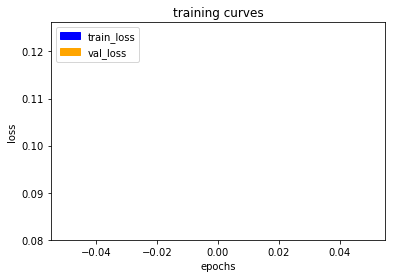

200/200 [==============================] - 82s - loss: 0.1239 - val_loss: 0.0821
Epoch 2/75
199/200 [============================>.] - ETA: 0s - loss: 0.0508

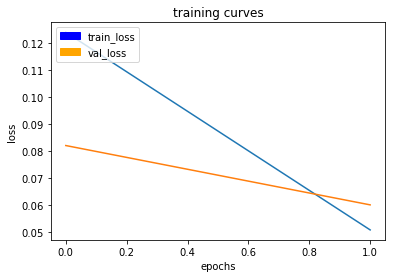

200/200 [==============================] - 79s - loss: 0.0509 - val_loss: 0.0602
Epoch 3/75
199/200 [============================>.] - ETA: 0s - loss: 0.0517

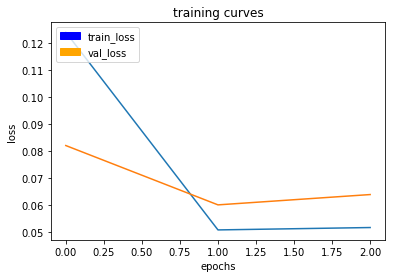

200/200 [==============================] - 79s - loss: 0.0518 - val_loss: 0.0640
Epoch 4/75
199/200 [============================>.] - ETA: 0s - loss: 0.0457

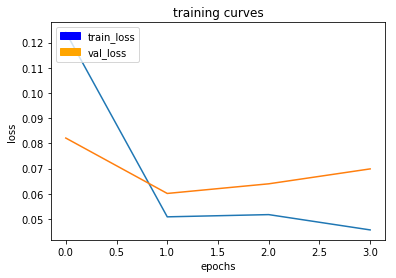

200/200 [==============================] - 79s - loss: 0.0457 - val_loss: 0.0699
Epoch 5/75
199/200 [============================>.] - ETA: 0s - loss: 0.0449

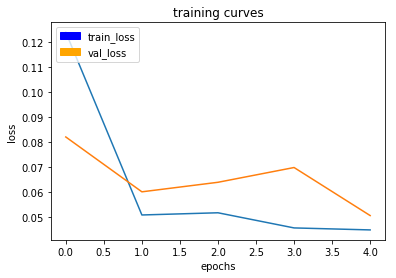

200/200 [==============================] - 79s - loss: 0.0449 - val_loss: 0.0506
Epoch 6/75
199/200 [============================>.] - ETA: 0s - loss: 0.0408

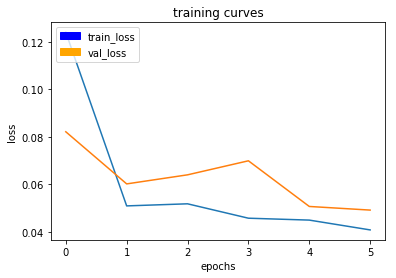

200/200 [==============================] - 79s - loss: 0.0407 - val_loss: 0.0491
Epoch 7/75
199/200 [============================>.] - ETA: 0s - loss: 0.0399

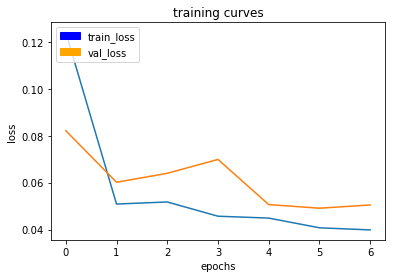

200/200 [==============================] - 79s - loss: 0.0398 - val_loss: 0.0505
Epoch 8/75
199/200 [============================>.] - ETA: 0s - loss: 0.0398

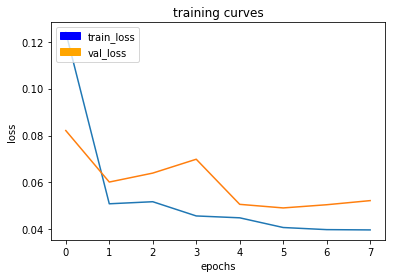

200/200 [==============================] - 79s - loss: 0.0398 - val_loss: 0.0522
Epoch 9/75
199/200 [============================>.] - ETA: 0s - loss: 0.0362

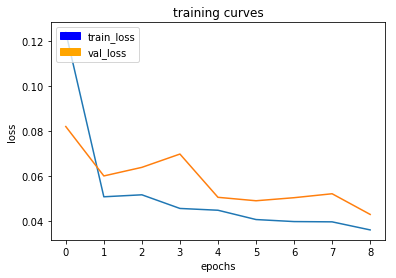

200/200 [==============================] - 79s - loss: 0.0361 - val_loss: 0.0430
Epoch 10/75
199/200 [============================>.] - ETA: 0s - loss: 0.0352

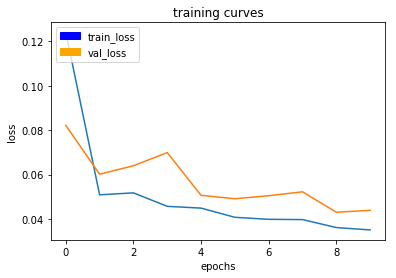

200/200 [==============================] - 79s - loss: 0.0351 - val_loss: 0.0439
Epoch 11/75
199/200 [============================>.] - ETA: 0s - loss: 0.0354

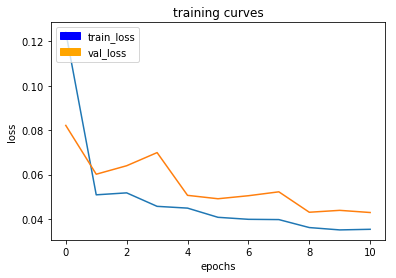

200/200 [==============================] - 79s - loss: 0.0354 - val_loss: 0.0429
Epoch 12/75
199/200 [============================>.] - ETA: 0s - loss: 0.0349

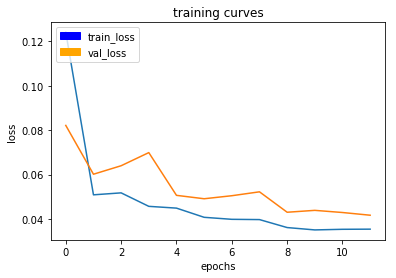

200/200 [==============================] - 79s - loss: 0.0354 - val_loss: 0.0417
Epoch 13/75
199/200 [============================>.] - ETA: 0s - loss: 0.0326

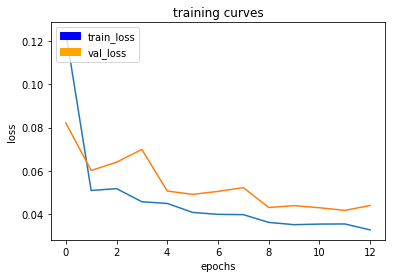

200/200 [==============================] - 79s - loss: 0.0326 - val_loss: 0.0440
Epoch 14/75
199/200 [============================>.] - ETA: 0s - loss: 0.0303

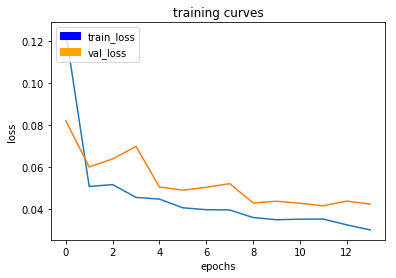

200/200 [==============================] - 79s - loss: 0.0303 - val_loss: 0.0425
Epoch 15/75
199/200 [============================>.] - ETA: 0s - loss: 0.0345

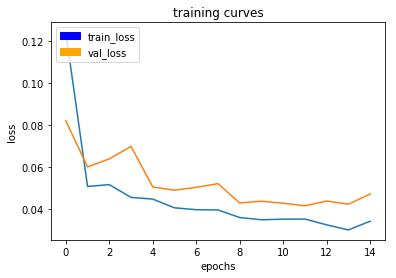

200/200 [==============================] - 79s - loss: 0.0344 - val_loss: 0.0473
Epoch 16/75
199/200 [============================>.] - ETA: 0s - loss: 0.0315

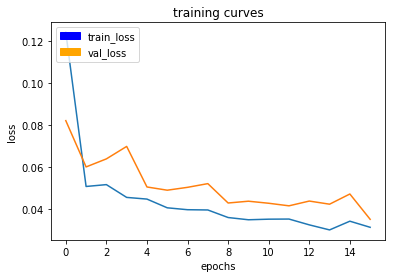

200/200 [==============================] - 79s - loss: 0.0315 - val_loss: 0.0353
Epoch 17/75
199/200 [============================>.] - ETA: 0s - loss: 0.0305

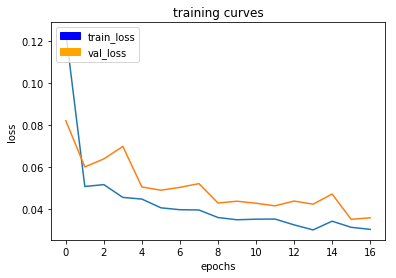

200/200 [==============================] - 79s - loss: 0.0305 - val_loss: 0.0360
Epoch 18/75
199/200 [============================>.] - ETA: 0s - loss: 0.0306

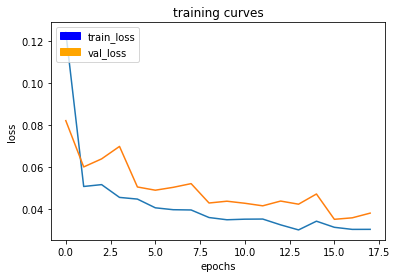

200/200 [==============================] - 79s - loss: 0.0305 - val_loss: 0.0382
Epoch 19/75
199/200 [============================>.] - ETA: 0s - loss: 0.0305

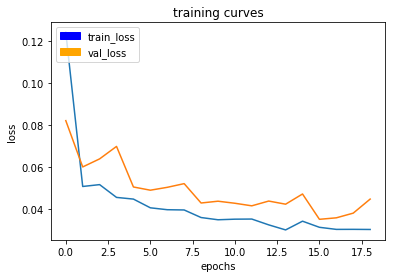

200/200 [==============================] - 79s - loss: 0.0305 - val_loss: 0.0449
Epoch 20/75
199/200 [============================>.] - ETA: 0s - loss: 0.0289

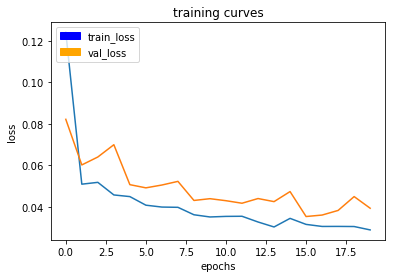

200/200 [==============================] - 79s - loss: 0.0289 - val_loss: 0.0393
Epoch 21/75
199/200 [============================>.] - ETA: 0s - loss: 0.0302

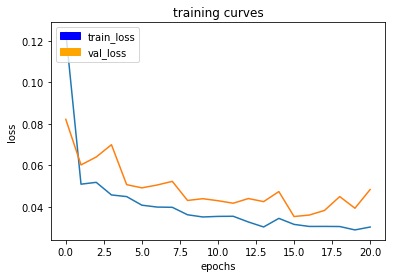

200/200 [==============================] - 79s - loss: 0.0302 - val_loss: 0.0483
Epoch 22/75
199/200 [============================>.] - ETA: 0s - loss: 0.0300

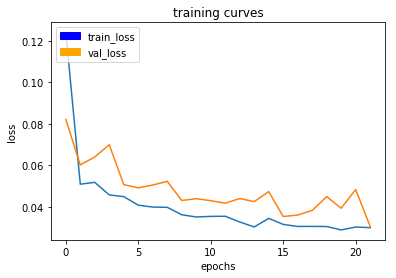

200/200 [==============================] - 79s - loss: 0.0300 - val_loss: 0.0305
Epoch 23/75
199/200 [============================>.] - ETA: 0s - loss: 0.0278

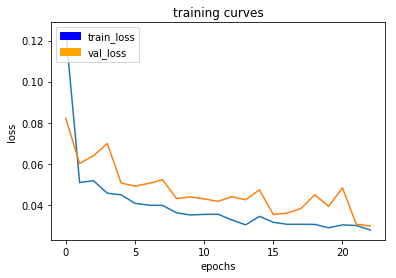

200/200 [==============================] - 79s - loss: 0.0278 - val_loss: 0.0298
Epoch 24/75
199/200 [============================>.] - ETA: 0s - loss: 0.0286

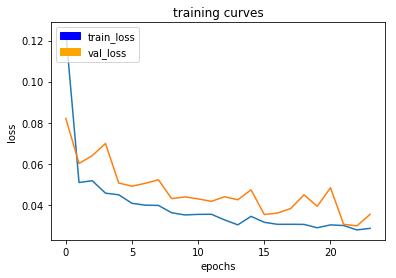

200/200 [==============================] - 79s - loss: 0.0285 - val_loss: 0.0354
Epoch 25/75
199/200 [============================>.] - ETA: 0s - loss: 0.0285

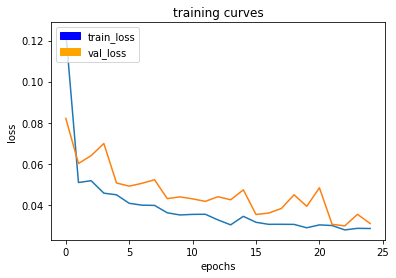

200/200 [==============================] - 79s - loss: 0.0285 - val_loss: 0.0309
Epoch 26/75
199/200 [============================>.] - ETA: 0s - loss: 0.0278

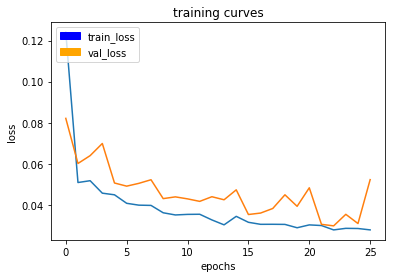

200/200 [==============================] - 79s - loss: 0.0278 - val_loss: 0.0523
Epoch 27/75
199/200 [============================>.] - ETA: 0s - loss: 0.0288

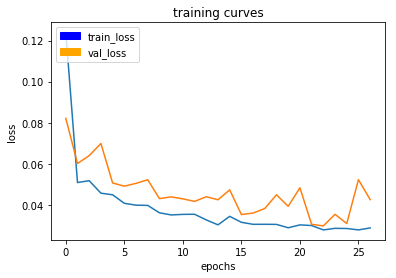

200/200 [==============================] - 79s - loss: 0.0288 - val_loss: 0.0426
Epoch 28/75
199/200 [============================>.] - ETA: 0s - loss: 0.0277

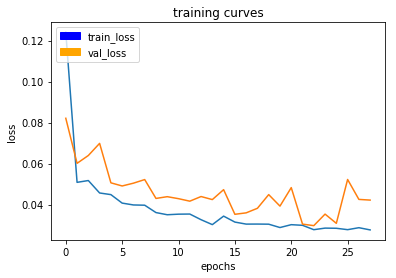

200/200 [==============================] - 79s - loss: 0.0277 - val_loss: 0.0422
Epoch 29/75
199/200 [============================>.] - ETA: 0s - loss: 0.0273

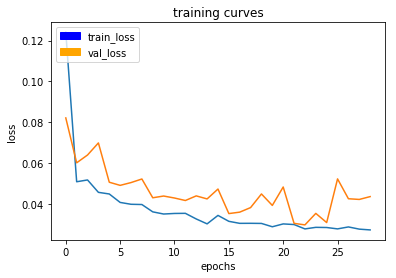

200/200 [==============================] - 79s - loss: 0.0273 - val_loss: 0.0436
Epoch 30/75
199/200 [============================>.] - ETA: 0s - loss: 0.0276

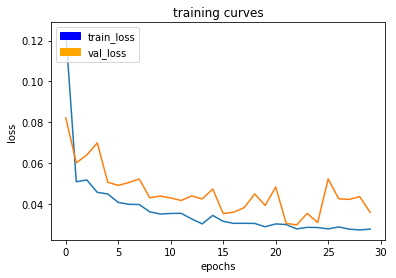

200/200 [==============================] - 79s - loss: 0.0276 - val_loss: 0.0359
Epoch 31/75
199/200 [============================>.] - ETA: 0s - loss: 0.0253

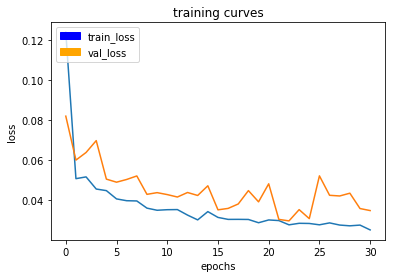

200/200 [==============================] - 79s - loss: 0.0253 - val_loss: 0.0349
Epoch 32/75
199/200 [============================>.] - ETA: 0s - loss: 0.0267

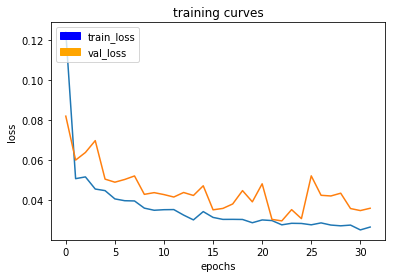

200/200 [==============================] - 79s - loss: 0.0267 - val_loss: 0.0361
Epoch 33/75
199/200 [============================>.] - ETA: 0s - loss: 0.0274

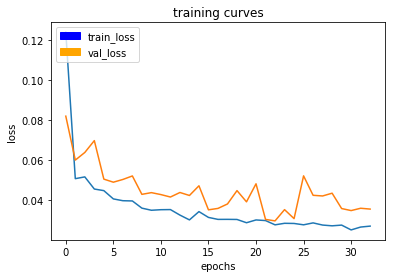

200/200 [==============================] - 79s - loss: 0.0274 - val_loss: 0.0357
Epoch 34/75
199/200 [============================>.] - ETA: 0s - loss: 0.0256

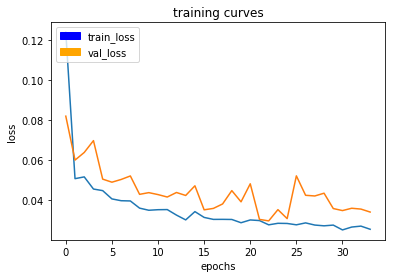

200/200 [==============================] - 79s - loss: 0.0256 - val_loss: 0.0342
Epoch 35/75
199/200 [============================>.] - ETA: 0s - loss: 0.0277

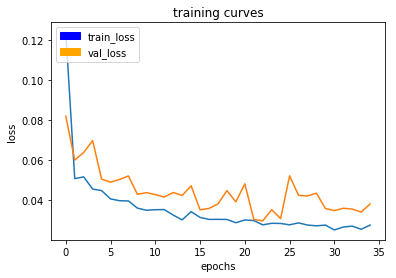

200/200 [==============================] - 79s - loss: 0.0277 - val_loss: 0.0382
Epoch 36/75
199/200 [============================>.] - ETA: 0s - loss: 0.0253

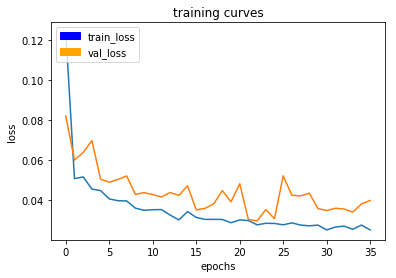

200/200 [==============================] - 79s - loss: 0.0252 - val_loss: 0.0400
Epoch 37/75
199/200 [============================>.] - ETA: 0s - loss: 0.0270

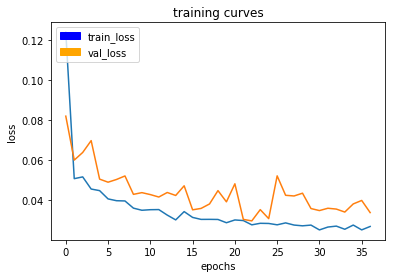

200/200 [==============================] - 79s - loss: 0.0270 - val_loss: 0.0339
Epoch 38/75
199/200 [============================>.] - ETA: 0s - loss: 0.0252

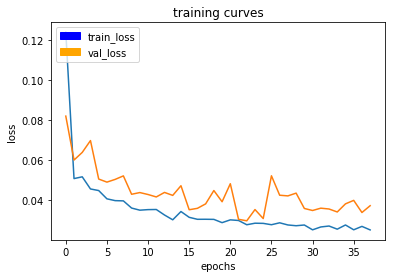

200/200 [==============================] - 79s - loss: 0.0252 - val_loss: 0.0373
Epoch 39/75
199/200 [============================>.] - ETA: 0s - loss: 0.0238

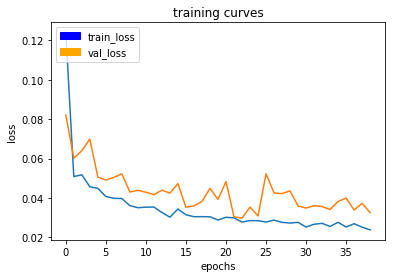

200/200 [==============================] - 79s - loss: 0.0238 - val_loss: 0.0325
Epoch 40/75
199/200 [============================>.] - ETA: 0s - loss: 0.0263

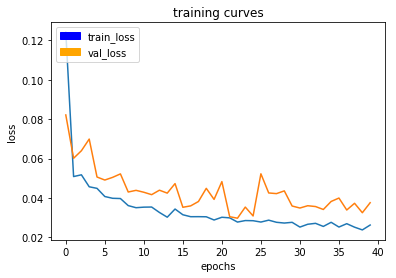

200/200 [==============================] - 79s - loss: 0.0263 - val_loss: 0.0376
Epoch 41/75
199/200 [============================>.] - ETA: 0s - loss: 0.0261

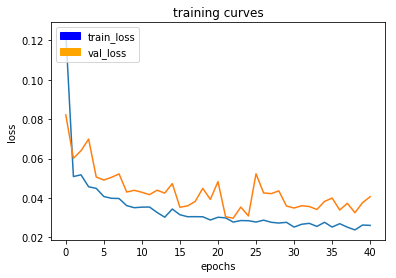

200/200 [==============================] - 79s - loss: 0.0261 - val_loss: 0.0407
Epoch 42/75
199/200 [============================>.] - ETA: 0s - loss: 0.0250

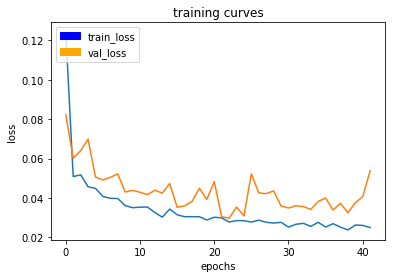

200/200 [==============================] - 79s - loss: 0.0250 - val_loss: 0.0538
Epoch 43/75
199/200 [============================>.] - ETA: 0s - loss: 0.0262

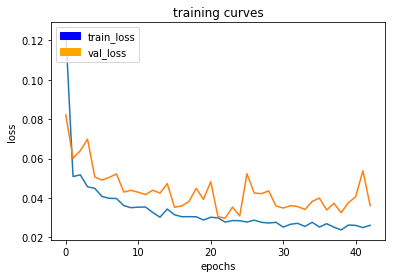

200/200 [==============================] - 79s - loss: 0.0261 - val_loss: 0.0361
Epoch 44/75
199/200 [============================>.] - ETA: 0s - loss: 0.0258

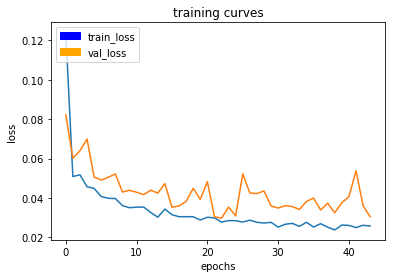

200/200 [==============================] - 79s - loss: 0.0260 - val_loss: 0.0305
Epoch 45/75
199/200 [============================>.] - ETA: 0s - loss: 0.0243

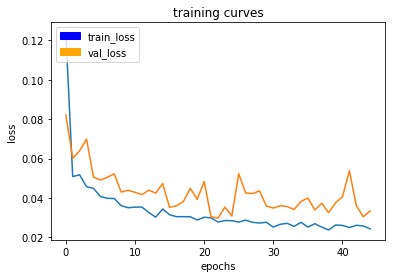

200/200 [==============================] - 79s - loss: 0.0244 - val_loss: 0.0334
Epoch 46/75
199/200 [============================>.] - ETA: 0s - loss: 0.0252

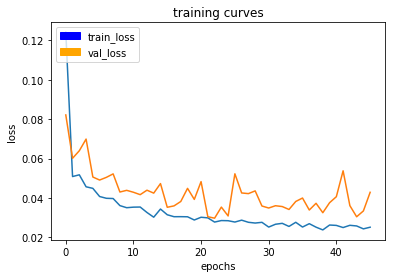

200/200 [==============================] - 79s - loss: 0.0252 - val_loss: 0.0429
Epoch 47/75
199/200 [============================>.] - ETA: 0s - loss: 0.0249

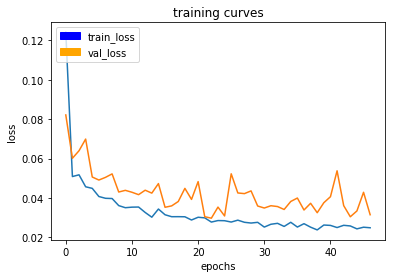

200/200 [==============================] - 79s - loss: 0.0249 - val_loss: 0.0315
Epoch 48/75
199/200 [============================>.] - ETA: 0s - loss: 0.0238

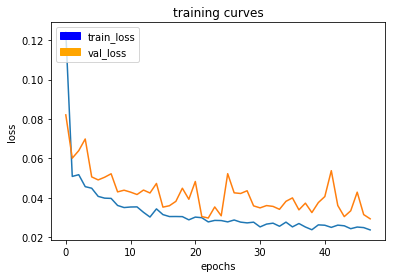

200/200 [==============================] - 79s - loss: 0.0237 - val_loss: 0.0294
Epoch 49/75
199/200 [============================>.] - ETA: 0s - loss: 0.0250

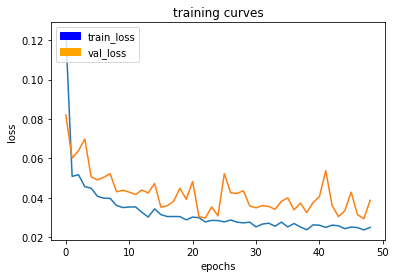

200/200 [==============================] - 79s - loss: 0.0250 - val_loss: 0.0388
Epoch 50/75
199/200 [============================>.] - ETA: 0s - loss: 0.0247

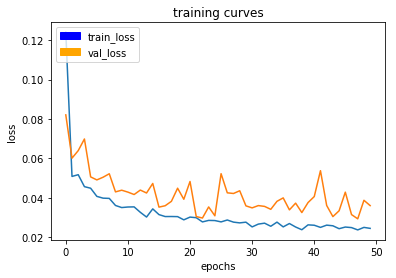

200/200 [==============================] - 79s - loss: 0.0246 - val_loss: 0.0361
Epoch 51/75
199/200 [============================>.] - ETA: 0s - loss: 0.0227

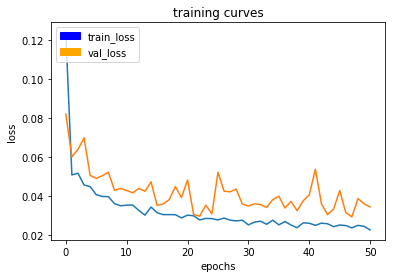

200/200 [==============================] - 79s - loss: 0.0227 - val_loss: 0.0345
Epoch 52/75
199/200 [============================>.] - ETA: 0s - loss: 0.0261

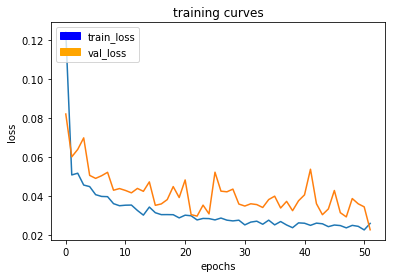

200/200 [==============================] - 79s - loss: 0.0261 - val_loss: 0.0228
Epoch 53/75
199/200 [============================>.] - ETA: 0s - loss: 0.0231

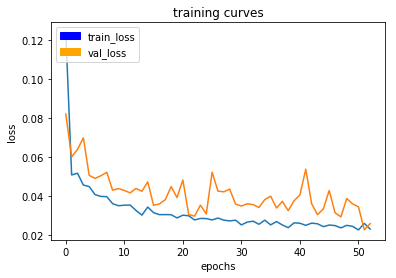

200/200 [==============================] - 79s - loss: 0.0231 - val_loss: 0.0259
Epoch 54/75
199/200 [============================>.] - ETA: 0s - loss: 0.0232

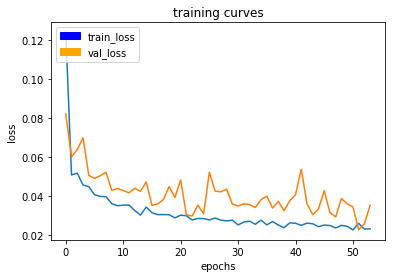

200/200 [==============================] - 79s - loss: 0.0232 - val_loss: 0.0354
Epoch 55/75
199/200 [============================>.] - ETA: 0s - loss: 0.0240

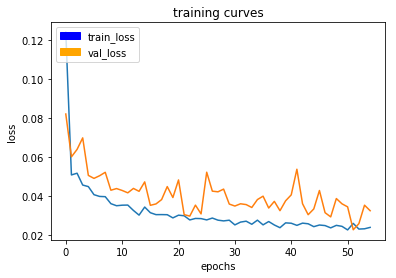

200/200 [==============================] - 79s - loss: 0.0240 - val_loss: 0.0325
Epoch 56/75
199/200 [============================>.] - ETA: 0s - loss: 0.0250

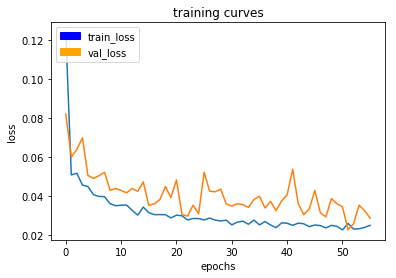

200/200 [==============================] - 79s - loss: 0.0250 - val_loss: 0.0287
Epoch 57/75
199/200 [============================>.] - ETA: 0s - loss: 0.0234

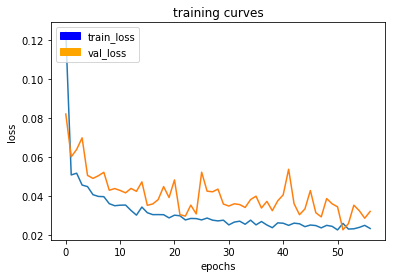

200/200 [==============================] - 79s - loss: 0.0234 - val_loss: 0.0322
Epoch 58/75
199/200 [============================>.] - ETA: 0s - loss: 0.0219

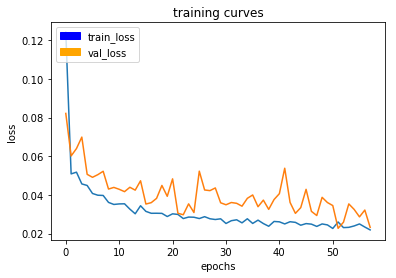

200/200 [==============================] - 79s - loss: 0.0219 - val_loss: 0.0232
Epoch 59/75
199/200 [============================>.] - ETA: 0s - loss: 0.0244

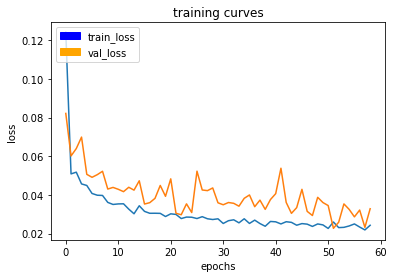

200/200 [==============================] - 79s - loss: 0.0243 - val_loss: 0.0329
Epoch 60/75
199/200 [============================>.] - ETA: 0s - loss: 0.0236

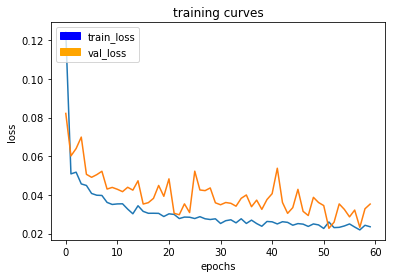

200/200 [==============================] - 80s - loss: 0.0236 - val_loss: 0.0353
Epoch 61/75
199/200 [============================>.] - ETA: 0s - loss: 0.0244

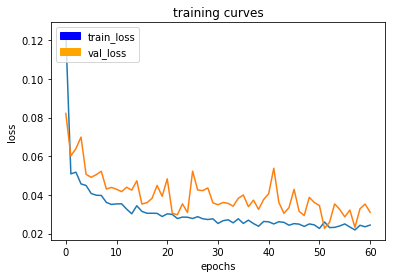

200/200 [==============================] - 79s - loss: 0.0244 - val_loss: 0.0310
Epoch 62/75
199/200 [============================>.] - ETA: 0s - loss: 0.0228

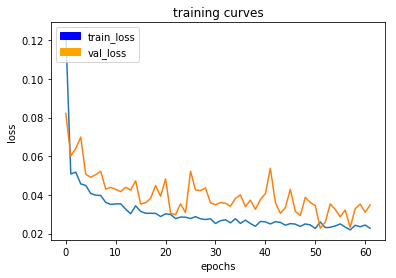

200/200 [==============================] - 79s - loss: 0.0228 - val_loss: 0.0348
Epoch 63/75
199/200 [============================>.] - ETA: 0s - loss: 0.0234

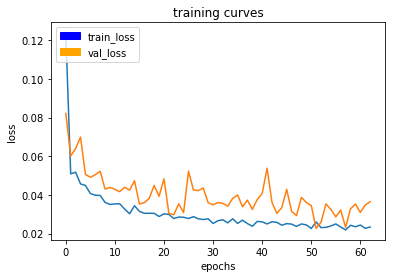

200/200 [==============================] - 79s - loss: 0.0234 - val_loss: 0.0365
Epoch 64/75
199/200 [============================>.] - ETA: 0s - loss: 0.0245

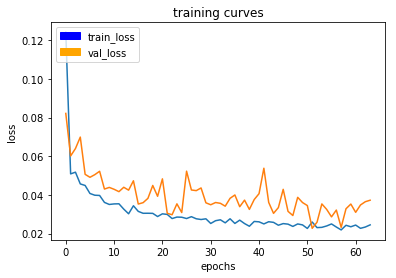

200/200 [==============================] - 79s - loss: 0.0245 - val_loss: 0.0373
Epoch 65/75
199/200 [============================>.] - ETA: 0s - loss: 0.0233

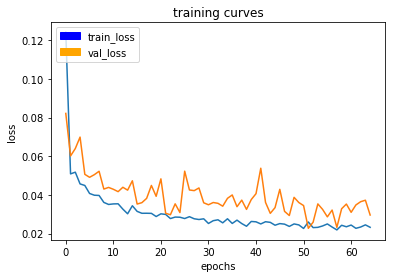

200/200 [==============================] - 80s - loss: 0.0233 - val_loss: 0.0296
Epoch 66/75
199/200 [============================>.] - ETA: 0s - loss: 0.0225

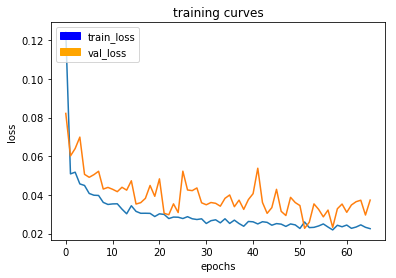

200/200 [==============================] - 79s - loss: 0.0226 - val_loss: 0.0373
Epoch 67/75
199/200 [============================>.] - ETA: 0s - loss: 0.0236

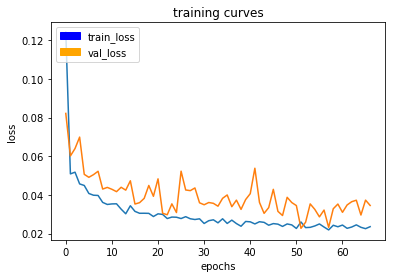

200/200 [==============================] - 79s - loss: 0.0236 - val_loss: 0.0346
Epoch 68/75
199/200 [============================>.] - ETA: 0s - loss: 0.0231

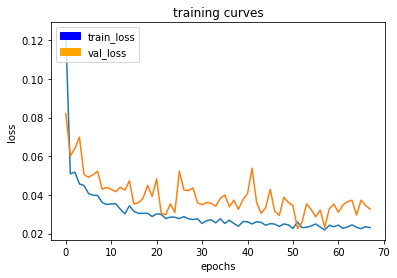

200/200 [==============================] - 79s - loss: 0.0231 - val_loss: 0.0327
Epoch 69/75
199/200 [============================>.] - ETA: 0s - loss: 0.0240

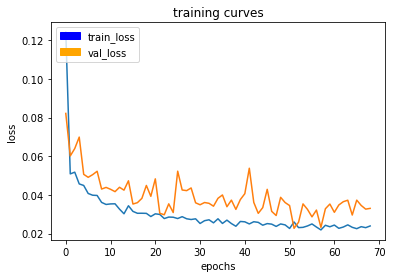

200/200 [==============================] - 79s - loss: 0.0240 - val_loss: 0.0331
Epoch 70/75
199/200 [============================>.] - ETA: 0s - loss: 0.0211

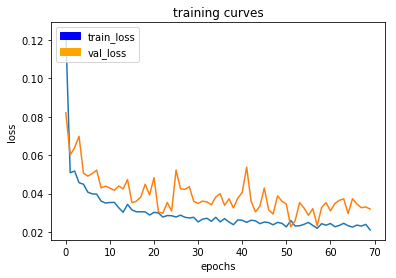

200/200 [==============================] - 79s - loss: 0.0211 - val_loss: 0.0320
Epoch 71/75
199/200 [============================>.] - ETA: 0s - loss: 0.0236

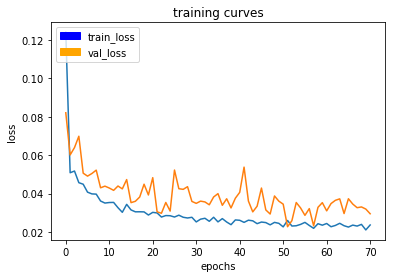

200/200 [==============================] - 79s - loss: 0.0237 - val_loss: 0.0295
Epoch 72/75
199/200 [============================>.] - ETA: 0s - loss: 0.0226

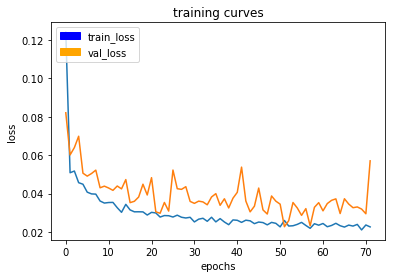

200/200 [==============================] - 79s - loss: 0.0227 - val_loss: 0.0571
Epoch 73/75
199/200 [============================>.] - ETA: 0s - loss: 0.0234

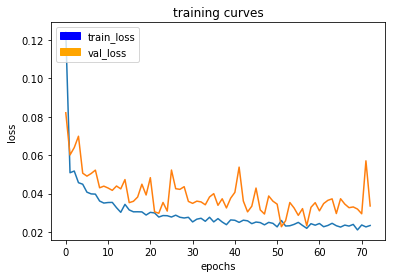

200/200 [==============================] - 79s - loss: 0.0234 - val_loss: 0.0336
Epoch 74/75
199/200 [============================>.] - ETA: 0s - loss: 0.0226

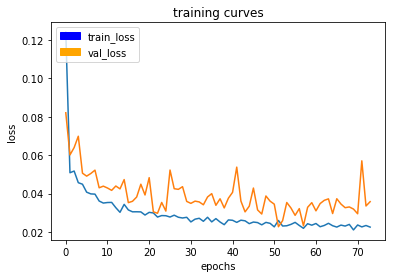

200/200 [==============================] - 79s - loss: 0.0226 - val_loss: 0.0358
Epoch 75/75
199/200 [============================>.] - ETA: 0s - loss: 0.0215

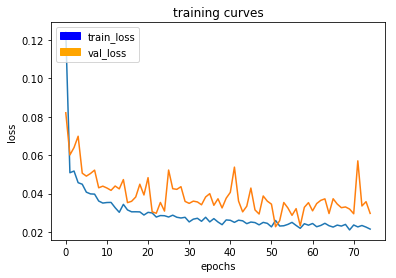

200/200 [==============================] - 79s - loss: 0.0215 - val_loss: 0.0297


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train_combined'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [11]:
# Save your trained model weights
# weight_file_name = 'model_weights'
# model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [8]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [9]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

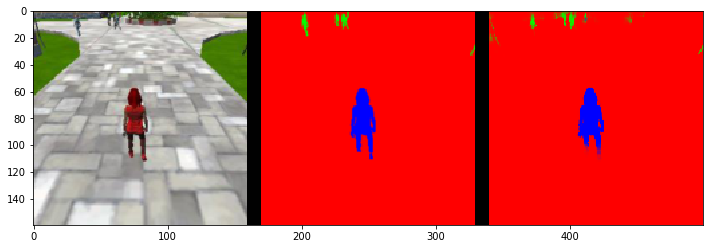

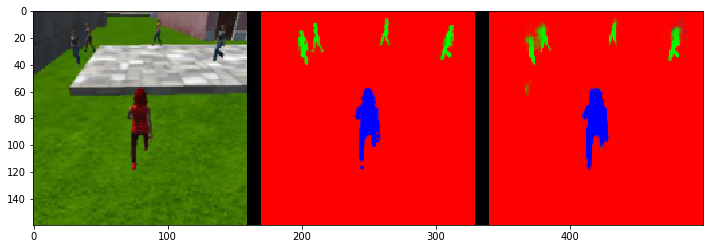

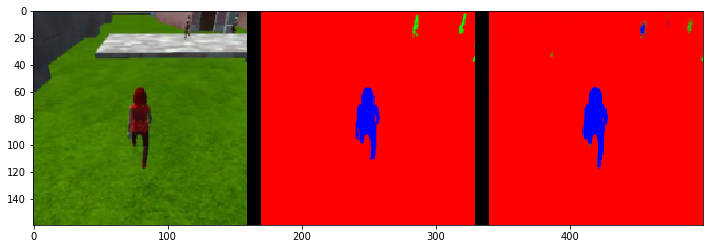

In [10]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

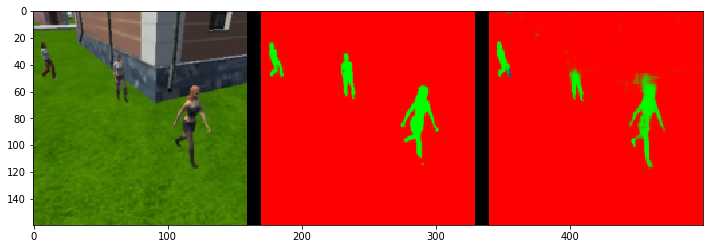

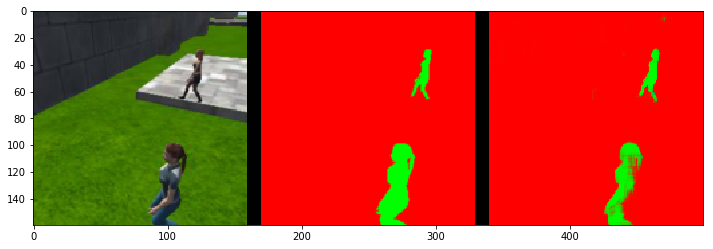

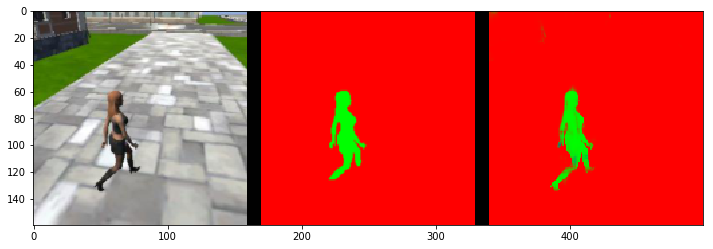

In [11]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

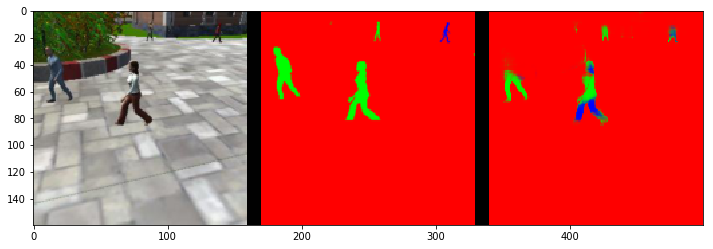

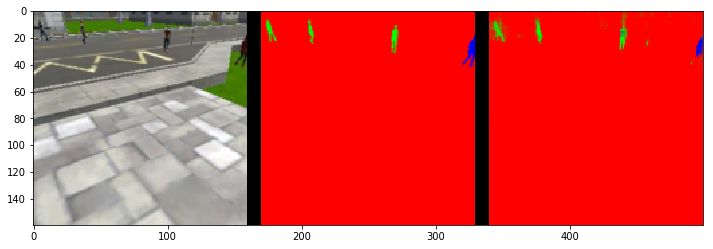

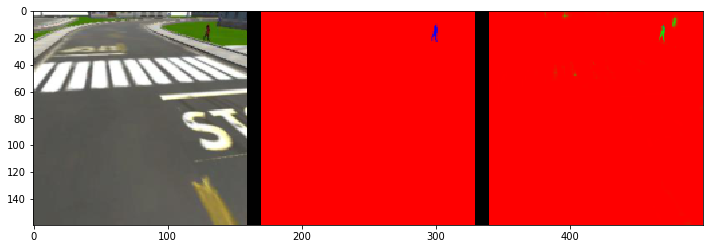

In [12]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [13]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9947625287710499
average intersection over union for other people is 0.3594131360556212
average intersection over union for the hero is 0.90070324841406
number true positives: 539, number false positives: 0, number false negatives: 0


In [14]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9835780249268802
average intersection over union for other people is 0.669303043278044
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 97, number false negatives: 0


In [15]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9960927432102781
average intersection over union for other people is 0.44838756576855154
average intersection over union for the hero is 0.31594726946765045
number true positives: 171, number false positives: 2, number false negatives: 130


In [16]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7561235356762513


In [17]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.6083252589408552


In [18]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.45996904563153057
